In [1]:
from typing import Tuple, List, Union, Optional
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### Plots best multiclass performance

In [2]:
sns.set_style('whitegrid')

In [20]:
audio = pd.read_json('../logs/aggregates/audio_performance.jsonl', lines=True)
audio["modality"] = np.where(~audio['model_name'].str.contains('ensemble'), "audio", 'ensemble')
text = pd.read_json('../logs/aggregates/text_performance.jsonl', lines=True)
text["modality"] = np.where(~text['model_name'].str.contains('ensemble'), "text", 'ensemble')
text["modality"] = "text"
ensemble = pd.read_json('../logs/aggregates/ensemble_performance_max.jsonl', lines=True)
ensemble["modality"] = "ensemble"
dummy = pd.read_json('../logs/aggregates/dummy_baseline.jsonl', lines=True)
dummy["modality"] = "dummy"

In [24]:
audio = pd.concat([audio, dummy], ignore_index=True)
text = pd.concat([text, dummy], ignore_index=True)
audio = pd.concat([audio, ensemble], ignore_index=True)
text = pd.concat([text, ensemble], ignore_index=True)

In [25]:
def _plot_multiclass_metrics(
        data: pd.DataFrame, 
        metric: str, 
        level: str, 
        figsize: Tuple[int, int], 
        modality: str, 
        target_class: str, 
        top_n: Optional[int]=None, 
        plot_model_id=False, 
        color_by: Optional[str]=None
        ):
    """Plots a metric for a target class. Options to plot top n models, color by a column,
    and to plot clean model id instead of the model name

    Args:
        data (pd.DataFrame): _description_
        metric (str): Which metric to plot (e.g. "f1_macro")
        level (str): id or overall
        figsize (Tuple[int, int]): figure size
        modality (str): audio, text - only used for the title and save name
        target_class (str): multiclass, ASD, DEPR, or SCHZ
        top_n (Optional[int], optional): Whether to only plot the top n models. Defaults to None.
        plot_model_id (bool, optional): Whether to plot a clean model id instead of the name. Defaults to False.
        color_by (Optional[str], optional): What to color by. 'modality' or 'model_type'. Defaults to None.

    Returns:
        _type_: _description_
    """

    model_id = "model_id" if plot_model_id else "model_name"
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(linestyle='dotted')
    if target_class == 'multiclass':
            df = data[(data['score_type'] == metric) & \
                      (data['level']==level) & \
                      (data['binary']==0)]
    else:
        df = data[(data['score_type'] == metric) & \
                  (data['level']==level) & \
                  (data['binary']==1) &
                  (data['target_class']==target_class)]
    df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
    df['model_name'] = np.where(df['is_baseline']==1 & ~df['model_name'].str.contains('baseline_'), 
                                'baseline_' + df['model_name'], 
                                df['model_name'])
    df = df.sort_values(by=['split', 'value'])
    df = df.replace({'validation': 'val'})
    if top_n is not None:
        def get_top_n_models(df, top_n):
            # get the top_n best model_name by value on test
            best_models = df[df['split']=='test'].sort_values(by='value', ascending=False)["model_name"].tolist()
            i = 0
            while True:
                best_mods = best_models[:top_n+i]
                if len(set(best_mods)) == top_n:
                    return best_mods
                i += 1
        best_models = get_top_n_models(df, top_n)
        df = df[df['model_name'].isin(best_models)]
        
    sns.lineplot(data=df,  
                 x='value', y=model_id, hue=model_id,
                 legend=False, 
                 palette=['grey']*df.model_name.nunique(), 
                 alpha=.2, ax=ax)
    sns.scatterplot(data=df, y=model_id, x='value', hue='split', 
                    palette=['grey',  'wheat', sns.color_palette()[3]], 
                    hue_order=['train', 'val', 'test'], 
                    marker='s', ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    from matplotlib.lines import Line2D
    handles = [Line2D([], [], color=h.get_facecolor()[0], marker='s', linestyle='None') 
               for h, l in zip(handles, labels)]
    labels, handles = zip(*(zip(labels, handles)))

    ax.legend(handles, labels, title="")
    plt.title(f'{modality} models, {target_class}')
    # color labels by baseline or transformer
    
    if color_by == "model_type":
        label_cols = ["grey" if "baseline" in model_n else "sienna" for model_n in df["model_name"].unique()]
        # update ensemble colors
        label_cols = ["steelblue" if "ensemble" in model_n else label_cols[i] 
                      for i, model_n in enumerate(df["model_name"].unique())]
        
    elif color_by == "modality":
        modality_color_mapping = {"Dummy" : "black", 
                                  "audio" : "darkorange", 
                                  "text" : "darkred", 
                                  "ensemble" : "grey"}
        df_modality = df.groupby("model_name")["modality"].first().to_dict()
        label_cols = [modality_color_mapping[df_modality[model_name]] 
                      for model_name in df["model_name"].unique()]
        
    if color_by is not None:
        [t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
        
    plt.xlim(0,1)
    plt.xlabel(f'{metric.replace("_", " ").capitalize()}')
    plt.ylabel('')
    plt.savefig(f"../figs/model_name_{metric}_{target_class}_{modality}.png", 
                bbox_inches="tight", dpi=600)
    plt.show()

/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_15466/205169664.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_name'] = df.model_name.apply(lambda x: x.split(r'_lr')[0])
/var/folders/zl/vvftwdh15f1cykb80f3t7l6c3djxb1/T/ipykernel_15466/205169664.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_name'] = np.where(df['is_baseline']==1 & ~df['model_name'].str.contains('baseline_'),


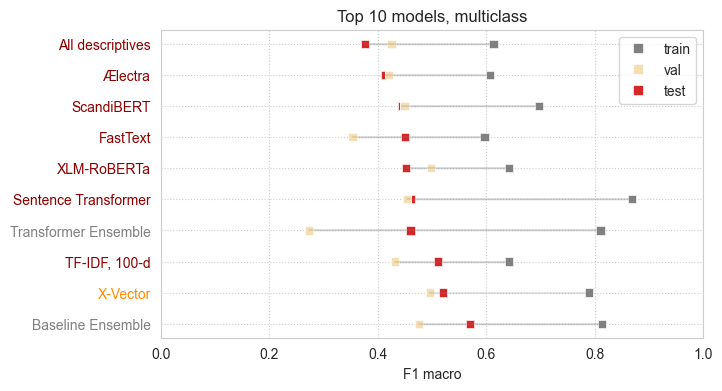

In [26]:
joint = pd.concat([text, audio], ignore_index=True)
mapping = json.load(open('../logs/model_name_mapping.json'))
joint['model_id'] = joint['model_name'].map(mapping)
_plot_multiclass_metrics(joint, 'f1_macro', 'id', (7,4), 'Top 10', 'multiclass', top_n=10, plot_model_id=True, color_by='modality')